## Load all session data

In [7]:
import sys
import os
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import pandas as pd
from ephys import *
from session_utils import find_all_sessions

# Load pickled data
df_all_sessions = pd.read_pickle('/home/isabella/Documents/isabella/jake/ephys_analysis/processed_data/df_all_cells.pkl')

# Load all session names and paths as dict
session_dict = find_all_sessions(sheet_path = 'https://docs.google.com/spreadsheets/d/1_Xs5i-rHNTywV-WuQ8-TZliSjTxQCCqGWOD2AL_LIq0/edit#gid=0',
                                 data_path = '/home/isabella/Documents/isabella/jake/recording_data',
                                 sorting_suffix = 'sorting_ks2_custom')

# Initialise DataFrame for ephys objects
df_all_sessions = pd.DataFrame(data = None, index = session_dict.keys(), columns = ['ephys_object'], dtype='object')

for i, session_path in enumerate(session_dict.values()):
    session = list(session_dict.keys())[i]

    # Create ephys object for session and add to dataframe
    obj = ephys(recording_type = 'nexus', path = session_path)
    df_all_sessions.at[list(session_dict.keys())[i], 'ephys_object'] = obj
    
    # df_all_sessions = pd.DataFrame(df_all_sessions.iloc[0,:]).T #TEMP FOR ONE SESSION ONLY
    # break #TEMP RUN FOR ONE SESSION ONLY
    
# # Drop rows with no included clusters
# df_all_cells = df_all_cells.dropna()
# print(f'{len(df_all_cells.index)} sessions retained')

df_all_sessions.head()

,ephys_object
230503_r1354,<ephys.ephys object at 0x7fa753837280>
230504_r1354,<ephys.ephys object at 0x7fa71a5f7850>
230505_r1354,<ephys.ephys object at 0x7fa7381d8490>
230506_r1354,<ephys.ephys object at 0x7fa6d756c550>
230507_r1354,<ephys.ephys object at 0x7fa71a3a4460>


## Select times when animal is in choice or return arms

In [10]:
from analysis.position_analysis import assign_sectors

# Loop through sessions
trials_loaded = 0
for row, obj in enumerate(df_all_sessions.loc[:, 'ephys_object']):
        
    # Load position for t-maze trials
    for trial_iterator, trial in enumerate(obj.trial_list):
        if 't-maze' in trial:
            obj.load_pos(trial_iterator, reload_flag = False)
            trials_loaded +=1
            
            # Assign sectors to positions samples
            sector_numbers = np.array(assign_sectors(obj.pos_data[trial_iterator]['xy_position'].T, pos_header = obj.pos_data[trial_iterator]['header']))
            
            # Define central and return arm position sectors
            central_sectors = [6, 7]
            return_sectors = [2, 3, 10, 11]
            
            # Find position samples where the animal is in each arm type
            central_samples = np.where(np.isin(sector_numbers, central_sectors))[0]
            return_samples = np.where(np.isin(sector_numbers, return_sectors))[0]
            
            # Get position sampling rate
            pos_sample_rate = obj.pos_data[trial_iterator]['pos_sampling_rate']
            
            #Convert these samples into times (in s) through the trial (divide by sample rate), then add to obj
            obj.pos_data[trial_iterator]['central_times'] = central_samples / pos_sample_rate
            obj.pos_data[trial_iterator]['return_times'] = return_samples / pos_sample_rate            
            
            df_all_sessions.at[list(session_dict.keys())[row], 'ephys_object'] = obj
            
                      
print(f'{trials_loaded} t-maze trials loaded')

Position data already loaded for trial 0
Position data already loaded for trial 2
Position data already loaded for trial 1
Position data already loaded for trial 3
Position data already loaded for trial 1
Position data already loaded for trial 3
Position data already loaded for trial 1
Position data already loaded for trial 1
Position data already loaded for trial 3
Position data already loaded for trial 1
Position data already loaded for trial 3
Position data already loaded for trial 1
Position data already loaded for trial 2
Position data already loaded for trial 3
Position data already loaded for trial 1
Position data already loaded for trial 1
Position data already loaded for trial 3
Position data already loaded for trial 1
Position data already loaded for trial 3
Position data already loaded for trial 1
Position data already loaded for trial 3
Position data already loaded for trial 1
Position data already loaded for trial 3
Position data already loaded for trial 1
Position data al

## Load theta phase and cycle for each t-maze trial

In [ ]:
from analysis.get_theta_frequencies import get_theta_frequencies
from analysis.get_theta_phase import get_theta_phase

lfp_sampling_rate = 1000
# channels_to_load = [35, 58, 37, 56, 39, 55, 40, 57, 38, 54, 41, 53, 42] # From generate 5x12/16 probe script, corresponding to central shank @0um to -1200um
channels_to_load = [35] # From generate 5x12/16 probe script, corresponding to central shank @0um

# Loop through sessions
for row, obj in enumerate(df_all_sessions.loc[:, 'ephys_object']):
    
    # Initalise object attribute to store theta phase data
    obj.cycle_data = [{}] * len(obj.trial_list)
    
    # Load central and return times for t-maze trials
    for trial_iterator, trial in enumerate(obj.trial_list):
        
        if 't-maze' in trial:

            # Load LFP for trial from contact on central shank at 0um (channel 15 on the 5x12/16 Buz probe)
            obj.load_lfp(trial_iterator,
                         sampling_rate = lfp_sampling_rate, 
                         channels  = channels_to_load, 
                         reload_flag = False,
                         scale_to_uv = True)
            
            # Find peak theta frequencies for channel @ 0um and make dict of {channel: theta_freq}
            theta_freqs = get_theta_frequencies(obj.lfp_data[trial_iterator]['data'], lfp_sampling_rate)
            theta_freqs = dict(zip(channels_to_load, theta_freqs))

            # Initialise theta phase array
            theta_phase = [None] * len(channels_to_load)
            cycle_numbers = [None] * len(channels_to_load)

            # Loop through each included channel
            for channel_iterator, channel in enumerate(channels_to_load):

                # Get peak theta frequency
                theta_freq = theta_freqs[channel]

                # Get LFP data for channel
                lfp_data_for_channel = obj.lfp_data[trial_iterator]['data'][:, channel_iterator]

                # Calculate theta phase
                theta_phase[channel_iterator], cycle_numbers[channel_iterator] = get_theta_phase(lfp_data_for_channel, lfp_sampling_rate, theta_freq)


            # Add theta phase data to object
            obj.cycle_data[trial_iterator]['theta_phase'] = np.array(theta_phase).T
            # Add cycle numbers data to object
            obj.cycle_data[trial_iterator]['cycle_numbers'] = np.array(cycle_numbers).T
            print(f'Loaded theta phase data for trial: {trial}')
                        
    df_all_sessions.at[list(session_dict.keys())[row], 'ephys_object'] = obj


Loaded theta phase data for trial: 230503_r1354_raw_t-maze_1
Loaded theta phase data for trial: 230504_r1354_raw_t-maze_1
Loaded theta phase data for trial: 230505_r1354_raw_t-maze_1
Loaded theta phase data for trial: 230505_r1354_raw_t-maze_2
Loaded theta phase data for trial: 230506_r1354_raw_t-maze_1
Loaded theta phase data for trial: 230506_r1354_raw_t-maze_2
Loaded theta phase data for trial: 230507_r1354_raw_t-maze_1
Loaded theta phase data for trial: 230508_r1354_raw_t-maze_1
Loaded theta phase data for trial: 230508_r1354_raw_t-maze_2
Loaded theta phase data for trial: 230509_r1354_raw_t-maze_1
Loaded theta phase data for trial: 230509_r1354_raw_t-maze_2
Loaded theta phase data for trial: 230510_r1354_raw_t-maze_1
Loaded theta phase data for trial: 230607_r1364_raw_t-maze_1
Loaded theta phase data for trial: 230607_r1364_raw_t-maze_2
Loaded theta phase data for trial: 230608_r1364_raw_t-maze_1
Loaded theta phase data for trial: 230609_r1364_raw_t-maze_1
Loaded theta phase data 

## For each t-maze trial - plot theta phase against frequency power

In [ ]:
from analysis.get_traversal_data import get_traversal_cycles, get_data_for_traversals, drop_extreme_cycles
from analysis.frequency_power import calculate_morlet_df, plot_wavelet_power_spectrum_theta
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# channels_to_load = [35, 58, 37, 56, 39, 55, 40, 57, 38, 54, 41, 53, 42] # From generate 5x12/16 probe script, corresponding to central shank @0um to -1200um
channels_to_load = [35]
figure_dir = '/home/isabella/Documents/isabella/jake/ephys_analysis/figures'

f_min = 30
f_max = 140
f_bins = 100

# Create dataframes for output
cycle_df = pd.DataFrame(columns=['Central Cycles', 'Return Cycles']).astype(object)
# central_mean_csd_df = pd.DataFrame()
# return_mean_csd_df = pd.DataFrame()
    
# Loop through sessions
for obj in df_all_sessions.loc[:, 'ephys_object']:
        
    # Loop through t-maze trials
    for trial_iterator, trial in ((i, t) for i, t in enumerate(obj.trial_list) if 't-maze' in t):
        
        # Set spectrogram save path
        spec_path = f'{figure_dir}/P{obj.age}_{obj.date_short}_{obj.animal}/spectrograms'
        # Check if the directory exists, if not, create it
        if not os.path.exists(csd_path):
            os.makedirs(csd_path)
        
        ## Get central and return arm times from object
        central_times = obj.pos_data[trial_iterator]['central_times']
        return_times = obj.pos_data[trial_iterator]['return_times']

        ## Load relevant lfp data from object
        cycle_numbers = obj.cycle_data[trial_iterator]['cycle_numbers']
        theta_phase = obj.cycle_data[trial_iterator]['theta_phase']
        lfp_timestamps = obj.lfp_data[trial_iterator]['timestamps']
        lfp_sampling_rate = obj.lfp_data[trial_iterator]['sampling_rate']


        ## Reload LFP data to include all relevant channels for wavelet calculation. This will load 13 channels worth of LFP data 
        # This will also write over the calculated metrics stored above
        obj.load_lfp(trial_iterator,
         sampling_rate = lfp_sampling_rate, 
         channels  = channels_to_load, 
         reload_flag = False, ##CAREFUL - CHANGE IF NEEDED
         scale_to_uv = True,
         bandpass_filter = freq_band)

        lfp_data = obj.lfp_data[trial_iterator]['data']

        ## Get speed data and align to LFP timestamps
        speed_data = obj.pos_data[trial_iterator]['speed']
        pos_sampling_rate = obj.pos_data[trial_iterator]['pos_sampling_rate']
        num_data_points = len(speed_data)
        # Original timestamps at 50 Hz
        original_timestamps = np.linspace(0, num_data_points/pos_sampling_rate, num=num_data_points, endpoint=True)
        # Create interpolation function
        interpolation_function = interp1d(original_timestamps, speed_data, kind='linear')
        # Interpolate to get new data at 1000 Hz
        resampled_speed_data = interpolation_function(lfp_timestamps)

        ## Calculate individual arm traversals and get identity of whole theta cycles within each traversal
        central_cycles = get_traversal_cycles(central_times, cycle_numbers, lfp_timestamps, lfp_sampling_rate)
        return_cycles = get_traversal_cycles(return_times, cycle_numbers, lfp_timestamps, lfp_sampling_rate)

        ## Get lfp trace, theta phase, timestamps, speed, cycle index and traversal index for included individual theta cycles
        central_cycle_df = get_data_for_traversals(central_cycles, cycle_numbers, lfp_data, resampled_speed_data, channels_to_load, theta_phase, lfp_timestamps)
        return_cycle_df = get_data_for_traversals(return_cycles, cycle_numbers, lfp_data, resampled_speed_data, channels_to_load, theta_phase, lfp_timestamps)

        ## Loop through each traversal in the dataframe and calculate frequency power, add to dataframe
        # Perform the wavelet transform for each included channel and add to dict
        morlet_dict = {}
        for channel in channels_to_load:
            central_morlet_df = calculate_morlet_df(arm_cycle_df = central_cycle_df,
                                            channel = channel,
                                            lfp_sampling_rate = lfp_sampling_rate,
                                            f_min = 1,
                                            f_max = 50,
                                            f_bins = 100)
            
            return_morlet_df = calculate_morlet_df(arm_cycle_df = central_cycle_df,
                                            channel = channel,
                                            lfp_sampling_rate = lfp_sampling_rate,
                                            f_min = 1,
                                            f_max = 50,
                                            f_bins = 100)
            
            # Drop the first and last theta cycle for each traversal to remove calculation artefacts
            central_morlet_df = drop_extreme_cycles(central_morlet_df)
            return_morlet_df = drop_extreme_cycles(return_morlet_df)
            
            ## Filter dataframe for speed > 2.5 cm/s
            central_morlet_df = central_morlet_df.loc[:, central_morlet_df.loc['Speed'] > 2.5]
            return_morlet_df = return_morlet_df.loc[:, return_morlet_df.loc['Speed'] > 2.5]
            
            ## Plot spectrogram for channel
            plot_wavelet_power_spectrum_theta(wavelet_coeffs = central_morlet_df.drop(['Traversal Index', 'Cycle Index', 'Cycle Theta Phase', 'Speed']).T.values,
                            theta_phase = central_morlet_df.loc(axis = 0)['Cycle Theta Phase'].to_numpy(),
                            n_theta_bins = 100, 
                            frequencies = central_morlet_df.index.drop(['Traversal Index', 'Cycle Index', 'Cycle Theta Phase', 'Speed']).to_list(),
                            arm = 'Central',
                            save_dir = f'{spec_path}/{trial}_morlet_spectrogram_Central_{f_min}-{f_max} Hz.png')
            
            plot_wavelet_power_spectrum_theta(wavelet_coeffs = return_morlet_df.drop(['Traversal Index', 'Cycle Index', 'Cycle Theta Phase', 'Speed']).T.values,
                            theta_phase = return_morlet_df.loc(axis = 0)['Cycle Theta Phase'].to_numpy(),
                            n_theta_bins = 100, 
                            frequencies = return_morlet_df.index.drop(['Traversal Index', 'Cycle Index', 'Cycle Theta Phase', 'Speed']).to_list(),
                            arm = 'Return',
                            save_dir = f'{spec_path}/{trial}_morlet_spectrogram_Return_{f_min}-{f_max} Hz.png')
            
            
            ## Add calculated wavelet coefficients to dict
            
            
        print(f'Calculated complex morlet wavelet transform for trial {trial}')

#         ## Add to dataframe for all sessions
#         mean_central_csd.columns = [trial]
#         central_mean_csd_df = pd.concat([central_mean_csd_df, mean_central_csd], axis=1)
        
#         mean_return_csd.columns = [trial]
#         return_mean_csd_df = pd.concat([return_mean_csd_df, mean_return_csd], axis=1)


## For each t-maze trial - compute CSD by arm for each theta cycle, plot and save result to dataframe

In [ ]:
from analysis.get_traversal_data import get_traversal_cycles, get_data_for_traversals, drop_extreme_cycles
from analysis.bz_csd import calculate_csd_df, mean_csd_theta_phase, plot_csd_theta_phase
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

channels_to_load = [35, 58, 37, 56, 39, 55, 40, 57, 38, 54, 41, 53, 42] # From generate 5x12/16 probe script, corresponding to central shank @0um to -1200um
channel_depths = np.arange(len(channels_to_load)) * -100
figure_dir = '/home/isabella/Documents/isabella/jake/ephys_analysis/figures'

freq_band = [4, 12]
freq_band_name = 'Theta'

# Create dataframes for output
cycle_df = pd.DataFrame(columns=['Central Cycles', 'Return Cycles']).astype(object)
central_mean_csd_df = pd.DataFrame()
return_mean_csd_df = pd.DataFrame()
    
# Loop through sessions
for obj in df_all_sessions.loc[:, 'ephys_object']:
        
    # Loop through t-maze trials
    for trial_iterator, trial in ((i, t) for i, t in enumerate(obj.trial_list) if 't-maze' in t):
        
        # Set CSD save path
        csd_path = f'{figure_dir}/P{obj.age}_{obj.date_short}_{obj.animal}/CSD'
        # Check if the directory exists, if not, create it
        if not os.path.exists(csd_path):
            os.makedirs(csd_path)
        
        ## Get central and return arm times from object
        central_times = obj.pos_data[trial_iterator]['central_times']
        return_times = obj.pos_data[trial_iterator]['return_times']

        ## Load relevant lfp data from object
        cycle_numbers = obj.cycle_data[trial_iterator]['cycle_numbers']
        theta_phase = obj.cycle_data[trial_iterator]['theta_phase']
        lfp_timestamps = obj.lfp_data[trial_iterator]['timestamps']
        lfp_sampling_rate = obj.lfp_data[trial_iterator]['sampling_rate']


        ## Reload LFP data to include all relevant channels for CSD calculation. This will load 13 channels worth of LFP data 
        # This will also write over the calculated metrics stored above
        obj.load_lfp(trial_iterator,
         sampling_rate = lfp_sampling_rate, 
         channels  = channels_to_load, 
         reload_flag = True,
         scale_to_uv = True,
         bandpass_filter = freq_band)

        lfp_data = obj.lfp_data[trial_iterator]['data']

        ## Get speed data and align to LFP timestamps
        speed_data = obj.pos_data[trial_iterator]['speed']
        pos_sampling_rate = obj.pos_data[trial_iterator]['pos_sampling_rate']
        num_data_points = len(speed_data)
        # Original timestamps at 50 Hz
        original_timestamps = np.linspace(0, num_data_points/pos_sampling_rate, num=num_data_points, endpoint=True)
        # Create interpolation function
        interpolation_function = interp1d(original_timestamps, speed_data, kind='linear')
        # Interpolate to get new data at 1000 Hz
        resampled_speed_data = interpolation_function(lfp_timestamps)

        ## Calculate individual arm traversals and get identity of whole theta cycles within each traversal
        central_cycles = get_traversal_cycles(central_times, cycle_numbers, lfp_timestamps, lfp_sampling_rate)
        return_cycles = get_traversal_cycles(return_times, cycle_numbers, lfp_timestamps, lfp_sampling_rate)

        ## Get lfp trace, theta phase, timestamps, speed, cycle index and traversal index for included individual theta cycles
        central_cycle_df = get_data_for_traversals(central_cycles, cycle_numbers, lfp_data, resampled_speed_data, channels_to_load, theta_phase, lfp_timestamps)
        return_cycle_df = get_data_for_traversals(return_cycles, cycle_numbers, lfp_data, resampled_speed_data, channels_to_load, theta_phase, lfp_timestamps)

        ## Loop through each traversal in the dataframe and calculate CSD, add to dataframe
        central_csd_df, central_csd_labels = calculate_csd_df(central_cycle_df)
        return_csd_df, return_csd_labels = calculate_csd_df(return_cycle_df)
        # Drop the first and last theta cycle for each traversal to remove calculation artefacts
        central_csd_df = drop_extreme_cycles(central_csd_df)
        return_cycle_df = drop_extreme_cycles(return_csd_df)

        ## Filter dataframe for speed > 2.5 cm/s
        central_csd_df = central_csd_df.loc[:, central_csd_df.loc['Speed'] > 2.5]
        return_csd_df = return_csd_df.loc[:, return_csd_df.loc['Speed'] > 2.5]
        
        print(f'Calculated CSD for trial {trial}')

        ## Compute mean CSD vs theta phase for each arm
        central_csd_theta_phase = mean_csd_theta_phase(central_csd_df, central_csd_labels)
        return_csd_theta_phase = mean_csd_theta_phase(return_csd_df, return_csd_labels)
        #Plot
        plot_csd_theta_phase(central_csd_theta_phase, 
                             title = f'Central Arm - {freq_band_name}', save_path = f'{csd_path}/{trial}_CSD_Theta_Phase_Central_{freq_band_name}.png')
        plot_csd_theta_phase(return_csd_theta_phase, 
                             title = f'Return Arm - {freq_band_name}', save_path = f'{csd_path}/{trial}_CSD_Theta_Phase_Return_{freq_band_name}.png')
        
        ## Calculate the difference and plot
        subtracted_csd_theta_phase = central_csd_theta_phase - return_csd_theta_phase
        plot_csd_theta_phase(subtracted_csd_theta_phase, title = f'Subtracted - {freq_band_name}')
        
        ## Mean csd for each channel and plot
        mean_central_csd = central_csd_df.mean(axis = 1)[central_csd_labels]
        mean_return_csd = return_csd_df.mean(axis = 1)[return_csd_labels]
        
        plt.plot(mean_central_csd.values, mean_central_csd.index, label = 'Centre', c = 'orange')
        plt.plot(mean_return_csd.values, mean_return_csd.index, label = 'Return', c = 'blue')
        plt.legend()
        plt.gca().invert_yaxis()
        plt.yticks(mean_central_csd.index.to_list(), channel_depths)
        plt.ylabel('Channel Depth (μm)')
        plt.axvline(x=0, color='grey', linestyle='--', dashes=[5, 5])
        plt.savefig(f'{csd_path}/{trial}_mean_CSD_{freq_band_name}.png')
        plt.title(f'Mean CSD - {freq_band_name}')
        plt.show()
    
        ## Add to dataframe for all sessions
        mean_central_csd.columns = [trial]
        central_mean_csd_df = pd.concat([central_mean_csd_df, mean_central_csd], axis=1)
        
        mean_return_csd.columns = [trial]
        return_mean_csd_df = pd.concat([return_mean_csd_df, mean_return_csd], axis=1)


### Plot mean CSD across all sessions

In [ ]:
plt.plot(central_mean_csd_df.mean(axis=1).values, central_mean_csd_df.mean(axis=1).index, c = 'orange', label = 'central')
plt.plot(return_mean_csd_df.mean(axis=1).values, return_mean_csd_df.mean(axis=1).index, c = 'blue', label = 'return')
plt.legend()
plt.gca().invert_yaxis()
plt.yticks(return_mean_csd_df.mean(axis=1).index.to_list(), channel_depths)
plt.axvline(x=0, color='grey', linestyle='--', dashes=[5, 5])
plt.ylabel('Channel Depth (μm)')
plt.xlabel('CSD')
plt.title(f'Mean CSD across all sessions - {freq_band_name}')
plt.savefig(f'{csd_path}/all_trials_mean_CSD_{freq_band_name}.png')
plt.show()

# UNUSED CODE

## Plot theta phase against frequency power

In [193]:
central_morlet_df

,43.984,43.985,43.986,43.987,43.988,43.989,43.990,43.991,43.992,43.993,...,552.518,552.519,552.520,552.521,552.522,552.523,552.524,552.525,552.526,552.527
1.0,-21814.119361+245.213973j,-21853.981006+246.377496j,-21902.371686+247.808893j,-21956.360689+249.416027j,-22011.913720+251.072092j,-22064.039067+252.620210j,-22107.715785+253.902605j,-22138.639162+254.784030j,-22153.176868+255.150386j,-22147.930443+254.894938j,...,-15680.836466-260.939422j,-15606.663175-258.988404j,-15551.177775-257.623329j,-15516.572800-256.913606j,-15502.504735-256.848942j,-15507.460703-257.382256j,-15529.204287-258.443674j,-15564.132383-259.920284j,-15606.551657-261.633348j,-15648.883185-263.344687j
6.444444444444445,-21692.720525+1572.598322j,-21731.798071+1580.039894j,-21779.228084+1589.194919j,-21832.140641+1599.474055j,-21886.585085+1610.066193j,-21937.673168+1619.967876j,-21980.487985+1628.169895j,-22010.813992+1633.807149j,-22025.094072+1636.149805j,-22020.000110+1634.515137j,...,-15508.111104-1669.742507j,-15435.211511-1657.252239j,-15380.613891-1648.509997j,-15346.464674-1643.959724j,-15332.426807-1643.535518j,-15337.018159-1646.936185j,-15358.048126-1653.714745j,-15391.987854-1663.148934j,-15433.261764-1674.095445j,-15474.448007-1685.030771j
11.88888888888889,-21396.916332+2866.568746j,-21434.089027+2880.041836j,-21479.185343+2896.618108j,-21529.482985+2915.230259j,-21581.234445+2934.409359j,-21629.802759+2952.338114j,-21670.523718+2967.188811j,-21699.398355+2977.394705j,-21713.052227+2981.634025j,-21708.328077+2978.670305j,...,-15087.908195-3026.886482j,-15018.110155-3004.218212j,-14965.676746-2988.338122j,-14932.642435-2980.049988j,-14918.685887-2979.234246j,-14922.399670-2985.345225j,-14941.704465-2997.573250j,-14973.251776-3014.610140j,-15011.752033-3034.385251j,-15050.164890-3054.139461j
17.333333333333336,-20934.626498+4099.903173j,-20968.838853+4118.962261j,-21010.308615+4142.413369j,-21056.542824+4168.745998j,-21104.109545+4195.881224j,-21148.762174+4221.247073j,-21186.229052+4242.256806j,-21212.847656+4256.693009j,-21225.527328+4262.684953j,-21221.376238+4258.482625j,...,-14433.143026-4290.463285j,-14368.186432-4258.271870j,-14319.138263-4235.688519j,-14287.859121-4223.850298j,-14274.052157-4222.587498j,-14276.426034-4231.127385j,-14293.074367-4248.323637j,-14320.928877-4272.324496j,-14355.144317-4300.199234j,-14389.272988-4328.042925j
22.77777777777778,-20318.189661+5247.140053j,-20348.487279+5271.156803j,-20385.161823+5300.712196j,-20426.023405+5333.901540j,-20468.057131+5368.103331j,-20507.532281+5400.074295j,-20540.695973+5426.552506j,-20564.330328+5444.741720j,-20575.719736+5452.282843j,-20572.323160+5446.968973j,...,-13563.884016-5421.591836j,-13505.371949-5380.805519j,-13460.843657-5352.136660j,-13431.930104-5337.018226j,-13418.366924-5335.235340j,-13419.016327-5345.812765j,-13432.200573-5367.304263j,-13455.221789-5397.374183j,-13483.821973-5432.326527j,-13512.336645-5467.237143j
28.22222222222222,-19563.982652+6285.308781j,-19589.544171+6313.494752j,-19620.418254+6348.187679j,-19654.781340+6387.150108j,-19690.122634+6427.302475j,-19723.334996+6464.834747j,-19751.292634+6495.914919j,-19771.315152+6517.257998j,-19781.140312+6526.092483j,-19778.651131+6519.825626j,...,-12506.662864-6385.659301j,-12456.017265-6337.451152j,-12417.028675-6303.480562j,-12391.050684-6285.429548j,-12377.858402-6283.044338j,-12376.499832-6295.178016j,-12385.573785-6320.130501j,-12402.830259-6355.157107j,-12424.721178-6395.915441j,-12446.528787-6436.620830j
33.66666666666667,-18691.917376+7194.578616j,-18712.081326+7226.013590j,-18736.346086+7264.715943j,-18763.305096+7308.187074j,-18791.021408+7352.987893j,-18817.097753+7394.863473j,-18839.122225+7429.534275j,-18855.026310+7453.331569j,-18863.063916+7463.160014j,-18861.600840+7456.123840j,...,-11293.566677-7153.407101j,-11251.989995-7099.159140j,-11219.421085-7060.814958j,-11196.898092-7040.251060j,-11184.241365-7037.182138j,-11180.710701-7050.325581j,-11185.219982-7077.781220j,-11196.029257-7116.482629

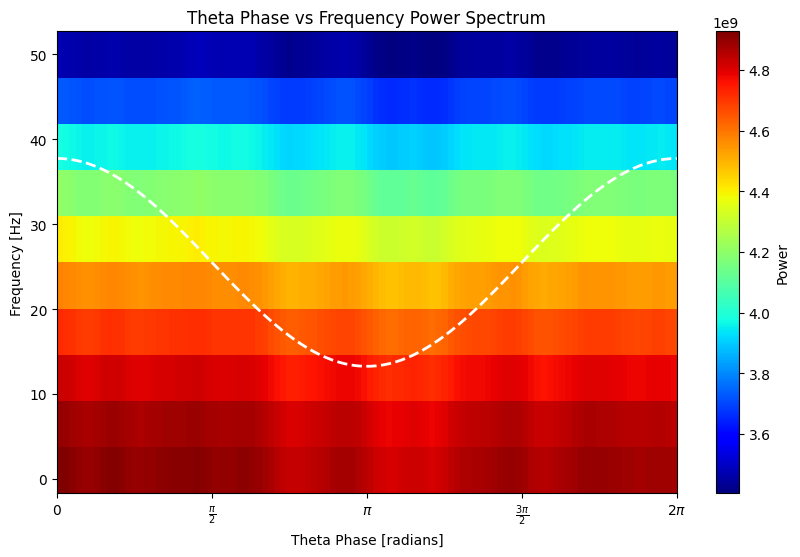

In [215]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from analysis.frequency_power import calculate_morlet_df

def plot_wavelet_power_spectrum_theta(wavelet_coeffs, theta_phase, n_theta_bins, frequencies, arm):
    """
    Plot a power spectrum across theta phase from the wavelet coefficients.

    :param wavelet_coeffs: Wavelet coefficients as returned by complex_morlet_wavelet_transform. 2D array of frequencies x timestamps
    :param theta_phase: 1D numpy array corresponding to theta phase for each timestamp
    :param n_theta_bins: number of theta bins to separate data into for plotting
    :param frequencies: Array of frequencies used in the wavelet transform
    """
    bin_edges = np.linspace(0, 2 * np.pi, n_theta_bins + 1)
    power_spectra = np.zeros((len(frequencies), n_theta_bins))
    
    for i in range(n_theta_bins):
        # Find indices for the current theta phase bin
        indices = np.where((theta_phase >= bin_edges[i]) & (theta_phase < bin_edges[i + 1]))[0]

        # Extract the wavelet coefficients for these indices
        selected_coeffs = wavelet_coeffs[indices, :]

        # Calculate the average power spectrum for this phase bin
        power_spectra[:, i] = np.mean(np.abs(selected_coeffs) ** 2, axis=0)
        
    # Smooth data across phase bins
    from scipy.ndimage import gaussian_filter1d
    # Apply this to each frequency bin
    sigma = 2  # Standard deviation for Gaussian kernel
    smoothed_power_spectra = np.array([gaussian_filter1d(power_spectra[i, :], sigma) for i in range(power_spectra.shape[0])])
    
    # Plotting
    theta_bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(theta_bin_centers, frequencies, smoothed_power_spectra, cmap='jet')
    plt.xlabel('Theta Phase [radians]')
    plt.ylabel('Frequency [Hz]')
    plt.colorbar(label='Power')
    plt.title('Theta Phase vs Frequency Power Spectrum')

    # Adjust the x-axis to show multiples of pi
    x_ticks = np.linspace(0, 2 * np.pi, 5)  # 0, pi/2, pi, 3pi/2, 2pi
    x_labels = ['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$']
    plt.xticks(x_ticks, x_labels)

    # Overlay a theta cycle
    theta_cycle = np.cos(np.linspace(0, 2 * np.pi, 100))
    theta_phase_values = np.linspace(0, 2 * np.pi, 100)
    offset = np.median(frequencies)  # Adjust as per your plot
    theta_cycle_normalized = theta_cycle * np.ptp(frequencies)/4 + offset
    plt.plot(theta_phase_values, theta_cycle_normalized, color='white', linestyle='--', linewidth=2)
    plt.title(f'Frequency Spectrogram across theta phase - {arm} Arm')

    plt.show()

# morlet_df = calculate_morlet_df(central_cycle_df, 35, 1000, 1, 50, 100)
morlet_df = central_morlet_df

plot_wavelet_power_spectrum(wavelet_coeffs = morlet_df.drop(['Traversal Index', 'Cycle Index', 'Cycle Theta Phase', 'Speed']).T.values,
                            theta_phase = morlet_df.loc(axis = 0)['Cycle Theta Phase'].to_numpy(),
                            n_theta_bins = 100, 
                            frequencies = morlet_df.index.drop(['Traversal Index', 'Cycle Index', 'Cycle Theta Phase', 'Speed']).to_list())

In [211]:
morlet_df.index.drop(['Traversal Index', 'Cycle Index', 'Cycle Theta Phase', 'Speed']).to_list()

[1.0,
 6.444444444444445,
 11.88888888888889,
 17.333333333333336,
 22.77777777777778,
 28.22222222222222,
 33.66666666666667,
 39.111111111111114,
 44.55555555555556,
 50.0]

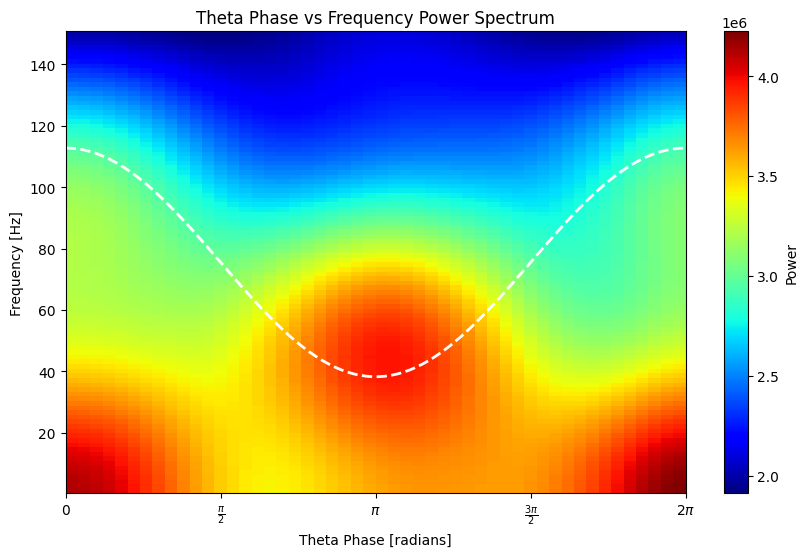

In [115]:
import matplotlib.pyplot as plt
from scipy.signal import morlet

def complex_morlet_wavelet_transform(signal, frequencies, fs):
    """
    Apply the complex Morlet wavelet transform to a signal for a range of frequencies.

    :param signal: The input signal (time series)
    :param frequencies: Array of frequencies for which to compute the transform
    :param fs: Sampling frequency of the input signal
    :return: An array of wavelet coefficients, time x frequencies
    """
    wavelet_coeffs = np.zeros((len(signal), len(frequencies)), dtype=complex)
    
    # Perform wavelet transform for each frequency
    for i, freq in enumerate(frequencies):
        # Calculate the wavelet for given frequency and sampling frequency
        wavelet = morlet(M=len(signal), w=5, s=freq / fs)
        # Convolve signal with the wavelet
        wavelet_coeffs[:, i] = np.convolve(signal, wavelet, mode='same')
    
    return wavelet_coeffs

def plot_wavelet_power_spectrum(wavelet_coeffs, times, frequencies):
    """
    Plot a time-resolved power spectrum from the wavelet coefficients.

    :param wavelet_coeffs: Wavelet coefficients as returned by complex_morlet_wavelet_transform
    :param times: Array of time points corresponding to the signal
    :param frequencies: Array of frequencies used in the wavelet transform
    """
    power_spectrum = np.abs(wavelet_coeffs) ** 2
    
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(times, frequencies, power_spectrum.T, cmap='jet')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.colorbar(label='Power')
    plt.title('Time-Resolved Power Spectrum')
    plt.tight_layout()
    
    
# Define the frequency range for the analysis
frequencies = np.linspace(1, 150, 100)  # (min_f, max_f, n_bins)
t_min = 50000
t_max = 100000
lfp_data = obj.lfp_data[1]['data'][t_min:t_max]
theta_phase = obj.lfp_data[1]['theta_phase'][t_min:t_max]

# Perform the wavelet transform
wavelet_coeffs = complex_morlet_wavelet_transform(lfp_data[:,0], frequencies, lfp_sampling_rate)

n_bins = 50  # Number of bins for theta phase
bin_edges = np.linspace(0, 2 * np.pi, n_bins + 1)
power_spectra = np.zeros((len(frequencies), n_bins))

for i in range(n_bins):
    # Find indices for the current theta phase bin
    indices = np.where((theta_phase >= bin_edges[i]) & (theta_phase < bin_edges[i + 1]))[0]

    # Extract the wavelet coefficients for these indices
    selected_coeffs = wavelet_coeffs[indices, :]

    # Calculate the average power spectrum for this phase bin
    power_spectra[:, i] = np.mean(np.abs(selected_coeffs) ** 2, axis=0)
    
# Smooth data across phase bins
from scipy.ndimage import gaussian_filter1d
# Apply this to each frequency bin
sigma = 2  # Standard deviation for Gaussian kernel
smoothed_power_spectra = np.array([gaussian_filter1d(power_spectra[i, :], sigma) for i in range(power_spectra.shape[0])])


# Plotting
theta_bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.figure(figsize=(10, 6))
plt.pcolormesh(theta_bin_centers, frequencies, smoothed_power_spectra, cmap='jet')
plt.xlabel('Theta Phase [radians]')
plt.ylabel('Frequency [Hz]')
plt.colorbar(label='Power')
plt.title('Theta Phase vs Frequency Power Spectrum')

# Adjust the x-axis to show multiples of pi
x_ticks = np.linspace(0, 2 * np.pi, 5)  # 0, pi/2, pi, 3pi/2, 2pi
x_labels = ['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$']
plt.xticks(x_ticks, x_labels)

# Overlay a theta cycle
theta_cycle = np.cos(np.linspace(0, 2 * np.pi, 100))
theta_phase_values = np.linspace(0, 2 * np.pi, 100)
offset = np.median(frequencies)  # Adjust as per your plot
theta_cycle_normalized = theta_cycle * np.ptp(frequencies)/4 + offset
plt.plot(theta_phase_values, theta_cycle_normalized, color='white', linestyle='--', linewidth=2)

plt.show()

# # Plot the power spectrum
# plot_wavelet_power_spectrum(wavelet_coeffs, obj.lfp_data[1]['timestamps'][t_min:t_max], frequencies)

# plt.plot(obj.lfp_data[1]['timestamps'][t_min:t_max], (filtered_lfp[t_min:t_max]/300)+50, c = 'w')
# plt.show()

## Plot mean frequency power spectrogram across theta phase for each session for contact at 0um, -300um, -600um from 20-200Hz

In [ ]:
from scipy.signal import hilbert, firwin, filtfilt, argrelmax
import matplotlib.pyplot as plt

# Find peak theta frequencies for each channel and make dict of {channel: theta_freq}
theta_freqs = get_theta_frequencies(obj.lfp_data[0]['data'], lfp_sampling_rate)
theta_freqs = dict(zip(channels_to_load, theta_freqs))

peak_freq = theta_freqs[15]
filt_half_bandwidth = 2
lfp = obj.lfp_data[0]['data'][:,0]

low_freq = peak_freq - filt_half_bandwidth
high_freq = peak_freq + filt_half_bandwidth
filter_taps = firwin(round(lfp_sampling_rate) + 1, [low_freq, high_freq], pass_zero=False, window='blackman', fs=lfp_sampling_rate)
pad_length = min(3 * (len(filter_taps) - 1), len(lfp) - 1)
filtered_lfp = filtfilt(filter_taps, 1, lfp, padlen=pad_length)

# find theta peaks (this is 0)
maxima = argrelmax(filtered_lfp[:2000])[0]

cycles = np.lib.stride_tricks.as_strided(maxima, shape=(maxima.size - 1, 2), strides=(maxima.strides[0], maxima.strides[0]))
cycles

# for cycle in cycles:
#     plt.plot(obj.lfp_data[0]['data'][cycle[0]:cycle[1],0])

plt.plot(obj.lfp_data[0]['data'][:2000,0])
    
# plt.scatter(argrelmax(filtered_lfp[:2000]), [0]*cycles, c = 'r')

plt.plot(filtered_lfp[:2000])


In [ ]:
plt.plot(theta_phase[0][:1000])
plt.plot((filtered_lfp[:1000]/2000)+np.pi)